In [1]:
# Author: 
# Human pose estimation : https://github.com/ZheC/Realtime_Multi-Person_Pose_Estimation
# Nature Cut out : Huiting Hong
import os
import sys
import cv2 as cv 
import numpy as np
import scipy
from scipy.ndimage.filters import gaussian_filter
import math
import caffe
import time
from config_reader import config_reader
import util
import copy
import matplotlib
%matplotlib inline
import pylab as plt
import pandas as pd
from shapely.ops import cascaded_union
from Alpha_shape import alpha_shape

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


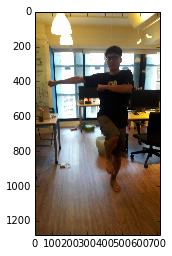

In [2]:
Overall_start_time = time.time()
file_id = 'wani12'
SubdirName = 'wani'
test_image = '../../input/'+SubdirName+'/'+file_id+'.jpg'
# test_image = '../../input/testImg27.jpg'

oriImg = cv.imread(test_image) # B,G,R order
# oriImg = cv.resize(oriImg,None,fx=0.2, fy=0.2, interpolation = cv.INTER_CUBIC)  # resize image to reduce computation cost
f = plt.imshow(oriImg[:,:,[2,1,0]]) # reorder it before displaying

In [3]:
start_time = time.time()
param, model = config_reader()
multiplier = [x * model['boxsize'] / oriImg.shape[0] for x in param['scale_search']]

read_config_t = (time.time() - start_time)

In [4]:
# first-time building the network structure will take around : 21.6 seconds
start_time = time.time()

if param['use_gpu']: 
    caffe.set_mode_gpu()
    caffe.set_device(param['GPUdeviceNumber']) # set to your device!
else:
    caffe.set_mode_cpu()
# caffe.set_mode_cpu()
net = caffe.Net(model['deployFile'], model['caffemodel'], caffe.TEST)

build_NN_from_caffe_t = (time.time() - start_time)

In [5]:
start_time_all = time.time()

heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model['stride'], model['padValue'])
    print imageToTest_padded.shape

    net.blobs['data'].reshape(*(1, 3, imageToTest_padded.shape[0], imageToTest_padded.shape[1]))
    #net.forward() # dry run
    net.blobs['data'].data[...] = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5;
    start_time = time.time()
    output_blobs = net.forward()
    print('At scale %d, The CNN took %.2f ms.' % (m, 1000 * (time.time() - start_time)))

    # extract outputs, resize, and remove padding
    heatmap = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[1]].data), (1,2,0)) # output 1 is heatmaps
    heatmap = cv.resize(heatmap, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
    
    paf = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[0]].data), (1,2,0)) # output 0 is PAFs
    paf = cv.resize(paf, (0,0), fx=model['stride'], fy=model['stride'], interpolation=cv.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
    paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)
    
    
    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)


Parts_heatmap_detection_t = (time.time() - start_time)

(184, 104, 3)
At scale 0, The CNN took 285.75 ms.
(368, 208, 3)
At scale 1, The CNN took 226.19 ms.
(552, 312, 3)
At scale 2, The CNN took 407.85 ms.
(736, 416, 3)
At scale 3, The CNN took 494.98 ms.


In [6]:
start_time = time.time()

## Generate the x-y position of each body-part.

#plt.imshow(heatmap_avg[:,:,2])

all_peaks = []
peak_counter = 0

for part in range(19-1):
    x_list = []
    y_list = []
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)
    
generate_position_of_body_part_t = (time.time() - start_time)

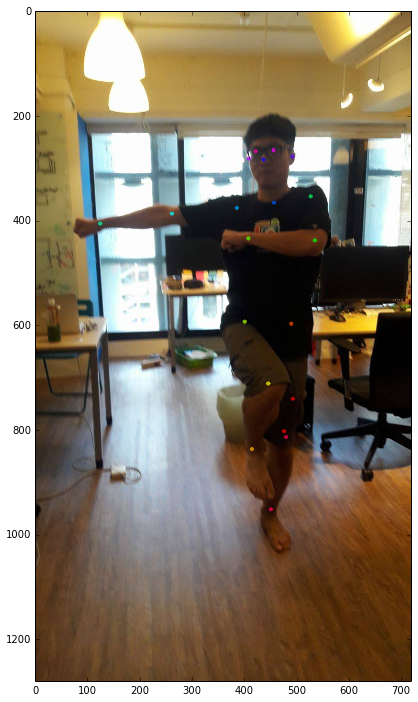

In [7]:
start_time = time.time()

# # visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv.imread(test_image) # B,G,R order
# canvas = cv.resize(canvas,None,fx=0.2, fy=0.2, interpolation = cv.INTER_CUBIC)  # resize image to reduce computation cost

N_tmp = 0
for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
#     print all_peaks[i]
#     print len(all_peaks[i])

    for j in range(len(all_peaks[i])):
#     for j in range(1):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)
        N_tmp += 1

to_plot = cv.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)
# print all_peaks
# print len(all_peaks)
# print N_tmp
visualize_body_landmarks_t = (time.time() - start_time)

In [8]:
start_time = time.time()

# Build landmarks as Dict
fdir = '../sample_image/'
img = oriImg
hei,wid,dep = img.shape

landmark_N = 18
x_posi = np.zeros(landmark_N)
y_posi = np.zeros(landmark_N)
posi_print = []
for i in range(landmark_N):
    for j in range(len(all_peaks[i])):
    	x_posi[i] = all_peaks[i][j][0]
    	y_posi[i] = all_peaks[i][j][1]

# save each position as the value in Dict
posi_Dict = {}
sorted_name = ['RAnk','RKne','RHip','LHip','LKne','LAnk','Pelv','Thrx','Neck','Head','RWri','RElb','RSho','LSho','LElb','LWri']
posi_name = ['Nose','Neck','RSho','RElb','RWri','LSho','LElb','LWri','RHip','RKne','RAnk','LHip','LKne','LAnk','REye','LEye','REar','LEar']
for i in range(landmark_N):
	posi_Dict[posi_name[i]] = np.array([int(x_posi[i]),int(y_posi[i])])

# add special landmark of 'Stom,Pelv' to make it more easy on finding contour points between stomach
pelv_x = (posi_Dict['LHip'][0]+posi_Dict['RHip'][0])/2 
pelv_y = (posi_Dict['LHip'][1]+posi_Dict['RHip'][1])/2
posi_Dict['Pelv'] = np.array([pelv_x,pelv_y])

stom_x = (posi_Dict['LHip'][0]+posi_Dict['RHip'][0])/4 + posi_Dict['Neck'][0]/2
stom_y = (posi_Dict['LHip'][1]+posi_Dict['RHip'][1])/4 + posi_Dict['Neck'][1]/2
posi_Dict['Stom'] = np.array([stom_x,stom_y])

thrx_x = (posi_Dict['Stom'][0]+posi_Dict['Neck'][0])/2
thrx_y = (posi_Dict['Stom'][1]+posi_Dict['Neck'][1])/2
posi_Dict['Thrx'] = np.array([thrx_x,thrx_y])

# head_x = ((2*posi_Dict['REye'][0]-1*posi_Dict['REar'][0])+(2*posi_Dict['LEye'][0]-1*posi_Dict['LEar'][0]))/2
# head_y = ((2*posi_Dict['REye'][1]-1*posi_Dict['REar'][1])+(2*posi_Dict['LEye'][1]-1*posi_Dict['LEar'][1]))/2
head_x = 2*posi_Dict['Nose'][0]-posi_Dict['Neck'][0]
head_y = 2*posi_Dict['Nose'][1]-posi_Dict['Neck'][1]
posi_Dict['Head'] = np.array([head_x,head_y])

# simply for print usage
for key, value in posi_Dict.items():
	posi_print.append([[int(value[0]),int(value[1])]])

# sort dict in original way
sorted_posi_Dict = {}
for i, ele in enumerate(sorted_name):
	sorted_posi_Dict[ele] = posi_Dict[ele]

sort_posi_Dict_t = (time.time() - start_time)

In [9]:
start_time = time.time()

## Build vectors

def ConnectLandmark(str1,str2,dataframe):
    dataframe.set_value(str1,str2,1)
    dataframe.set_value(str2,str1,1)

## Build Connection Matrix (but actually only need the info in the upper-triangle)
columns = sorted_name
index = sorted_name
df = pd.DataFrame(0,index = index, columns = columns)
ConnectLandmark('Head','Neck',df)
ConnectLandmark('Thrx','Neck',df)
ConnectLandmark('Thrx','LSho',df)
ConnectLandmark('Thrx','RSho',df)
ConnectLandmark('Thrx','Pelv',df)
ConnectLandmark('LSho','LElb',df)
ConnectLandmark('LElb','LWri',df)
ConnectLandmark('RSho','RElb',df)
ConnectLandmark('RElb','RWri',df)
ConnectLandmark('Pelv','RHip',df)
ConnectLandmark('Pelv','LHip',df)
ConnectLandmark('RHip','RKne',df)
ConnectLandmark('RAnk','RKne',df)
ConnectLandmark('LKne','LHip',df)
ConnectLandmark('LKne','LAnk',df)

# print(df)

## Build Vector between landmarks
vec_Dict = {}
idx = 0
for row, col in df.iterrows():
	for j in range(idx,len(col)): # only search upper triangular part
		if col[j] == 1: # find connection, then build vector.
			vecH = row
			vecT = col.index[j]
			vec_Dict[vecH+'_'+vecT] = sorted_posi_Dict[vecT] - sorted_posi_Dict[vecH]

			# normalization
			vec_Dict[vecH+'_'+vecT] = vec_Dict[vecH+'_'+vecT]/np.linalg.norm(vec_Dict[vecH+'_'+vecT])
	idx += 1

build_vector_t = (time.time() - start_time)

In [10]:
start_time = time.time()

## Start marking out the extending point

# set the width we would like to extend from the considered-point
width = 1.5*(np.linalg.norm(sorted_posi_Dict['LHip']-sorted_posi_Dict['RHip']))

# build clear relation between vector and its considered-point 
# (i.e. a vector is built from 2 points(considered-points), we have to make it clear which point is we would like to extend out base on this vector)
VecExtenPt_Dict = {}
VecExtenPt_Dict['RAnk_RKne'] = ['RKne','RAnk']
VecExtenPt_Dict['RKne_RHip'] = ['RHip']
VecExtenPt_Dict['LHip_LKne'] = ['LHip']
VecExtenPt_Dict['LKne_LAnk'] = ['LKne','LAnk']
VecExtenPt_Dict['Pelv_Thrx'] = ['Stom']
VecExtenPt_Dict['Thrx_Neck'] = ['Neck']
VecExtenPt_Dict['Neck_Head'] = ['Head']
VecExtenPt_Dict['RWri_RElb'] = ['RElb','RWri']
VecExtenPt_Dict['RElb_RSho'] = ['RSho']
VecExtenPt_Dict['LSho_LElb'] = ['LSho']
VecExtenPt_Dict['LElb_LWri'] = ['LElb','LWri']

# calculate extended-points regardless of its order
extendPt = []
extendPt_Draw = []
vtxs = ['Head','LWri','RWri','LAnk','RAnk'] # special cases on the 5 vertex pts
vtxs_WidFactor = [0.7]+[1.5]*4 # special 
vtxs_PairPts = ['Neck','LElb','RElb','LKne','RKne']

def AppendExtPts(pt):
    
    extendPt_x = pt[0]
    extendPt_y = pt[1]
    if extendPt_x>=0 and extendPt_x<hei and extendPt_y>=0 and extendPt_y<wid:
        return pt
    elif extendPt_x<0 or extendPt_x>=hei or extendPt_y<0 or extendPt_y>=wid:
        if extendPt_x<0:
            extendPt_x = 0
        if extendPt_x>=hei:
            extendPt_x=hei-1
        if extendPt_y<0:
            extendPt_y = 0
        if extendPt_y >= wid:
            extendPt_y = wid-1
        return [extendPt_x,extendPt_y]
    else:
        return None
        
for key, value in vec_Dict.items():
    # eg. key = RAnk_RKne; VecExtenPt_Dict['RAnk_RKne'] = 'RAnk'; sorted_posi_Dict['RAnk'] will get the posi.
    try :
        for i,ele in enumerate(VecExtenPt_Dict[key]): # usually enumerate once, but like in ['LKne','LHip'], we have to apply same norm on multi-considered-pts.
            extendpt = sorted_posi_Dict[ele]

            # special case on 5 extending pts(head,LWrist,RWrist,LAnkle,RAnkle), 
            '''
            Now I recalculate again the vector of these special vertex, since I am not sure 
            if the direction of previous calculated vector is what I want(have to look at the vec_Dict key name though..), 
            if I need choose on testing on its direction and then adjust it, it would be too non-intuitive.
            '''
            for idx, vertex in enumerate(vtxs):
                if ele == vertex:
                    pair = vtxs_PairPts[idx]
                    slope = (sorted_posi_Dict[vertex] - sorted_posi_Dict[pair])/np.linalg.norm(sorted_posi_Dict[vertex] - sorted_posi_Dict[pair])
                    extendPt.append([int(x) for x in (extendpt+width*slope*vtxs_WidFactor[idx])])

            norm = np.array([value[1],-value[0]]) # the vector of norm is (b,-a)
            extendPt.append([int(x) for x in (extendpt+width*norm)])
            extendPt.append([int(x) for x in (extendpt+width*(-norm))])

    except KeyError:
        continue

# for drawing purpose
extendPt_Draw = [[x] for x in extendPt]
extendPt = np.array(extendPt)

maxDif_ydir = max(extendPt[:,1])-min(extendPt[:,1])
maxDif_xdir = max(extendPt[:,0])-min(extendPt[:,0])
# print extendPt

calculate_extension_point_t = (time.time() - start_time)

In [11]:
start_time = time.time()

## Start Connecting These extend-pts (using Bezier Curve)
# use Alpha shape to remain those really important pts.
# [Note]: with larger alpha-value, we can find more fitting contour (but can't be too large(i.e. threshold would be too small, and so no more triangles could be added into the contour set, which will cause error.))
alpha = 4.1/max(maxDif_ydir,maxDif_xdir) # why 3.5? -> it's just exp. result. [eg. 1200 pt in 'maximum-y-diff', we will use 0.003 as alpha-value]
triangles, edge_points = alpha_shape(extendPt, alpha)

# extract vertices of Polygon
ExtPts_x, ExtPts_y = cascaded_union(triangles).exterior.coords.xy #extract these control points from alpha-shape-result
ExtPts = []
for i in range(len(ExtPts_x)):
    ExtPts.append([int(ExtPts_x[i]),int(ExtPts_y[i])])

ExtPts_Draw = [[x] for x in ExtPts]

Extract_vertices_of_Polygon_t = (time.time() - start_time)
start_time = time.time()

# use 4 points Bezier Curve
# inserts more points between any other two points
Dense_BezierCurve = []
insertN = 10.0
for idx,ele in enumerate(ExtPts):
    Dense_BezierCurve.append(ele)
    if idx < len(ExtPts)-1:
        for i in range(1,int(insertN)):
            insert_x = ele[0]*((int(insertN)-i)/insertN)+ExtPts[idx+1][0]*(i/insertN)
            insert_y = ele[1]*((int(insertN)-i)/insertN)+ExtPts[idx+1][1]*(i/insertN)
            Dense_BezierCurve.append([int(round(insert_x)),int(round(insert_y))])
            
Dense_BezierCurve_draw = [[x] for x in Dense_BezierCurve]

Interpolat_pts_t = (time.time() - start_time)
start_time = time.time()

# This Bezier function is wrote by https://stackoverflow.com/questions/246525/how-can-i-draw-a-bezier-curve-using-pythons-pil
def my_bezier(xys,ts):
    n = len(xys)
    combinations = pascal_row(n-1)
    # This uses the generalized formula for bezier curves
    # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization
    result = []
    for t in ts:
        tpowers = (t**i for i in range(n))
        upowers = reversed([(1-t)**i for i in range(n)])
        coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]
        result.append(
            tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))
    return result

def pascal_row(n):
    # This returns the nth row of Pascal's Triangle
    result = [1]
    x, numerator = 1, n
    for denominator in range(1, n//2+1):
        # print(numerator,denominator,x)
        x *= numerator
        x /= denominator
        result.append(x)
        numerator -= 1
    if n&1 == 0:
        # n is even
        result.extend(reversed(result[:-1]))
    else:
        result.extend(reversed(result)) 
    return result

s_vals = np.linspace(0.0, 1.0, 100)
points = my_bezier(Dense_BezierCurve,s_vals)

reconstruct_bezier_t = (time.time() - start_time)

points_draw = []
for i,ele in enumerate(points):
    points_draw.append([[int(round(ele[0])),int(round(ele[1]))]])



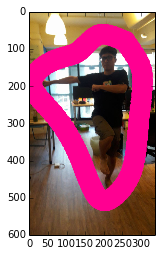

In [12]:
start_time = time.time()

## Show the result

# in case the image is too big to show on the screen.
newHei = 600.0
ratio = newHei/hei
newWid = int(wid*ratio)
newHei = int(newHei)

ptS = int(hei/100) # why 100? -> it's just exp. result.

# #Show HPE result
# img_HPE = img.copy()
# cv.drawContours(img_HPE, np.asarray(posi_print), -1, (128,255,0), ptS)
# img_HPE_extend = cv.resize(img_HPE,(newWid, newHei), interpolation = cv.INTER_CUBIC)
# plt.imshow(img_HPE[:,:,[2,1,0]])

# #Show Extending points result
# img_HPE_extend = img.copy()
# cv.drawContours(img_HPE_extend, np.asarray(extendPt_Draw), -1, (128,255,0), ptS)
# img_HPE_extend = cv.resize(img_HPE_extend,(newWid, newHei), interpolation = cv.INTER_CUBIC)
# plt.imshow(img_HPE_extend[:,:,[2,1,0]])

# #Show Applying Alpha-Shape result
# img_AlphaShape = img.copy()
# cv.drawContours(img_AlphaShape, np.asarray(ExtPts_Draw), -1, (128,255,0), ptS)
# img_AlphaShape = cv.resize(img_AlphaShape,(newWid, newHei), interpolation = cv.INTER_CUBIC)
# plt.imshow(img_AlphaShape[:,:,[2,1,0]])

# Show Final reconstruct curve
img_NatureCurve = img.copy()
cv.drawContours(img_NatureCurve, np.asarray(points_draw), -1, (145, 0, 255), ptS*10)
img_NatureCurve = cv.resize(img_NatureCurve,(newWid, newHei), interpolation = cv.INTER_CUBIC)
plt.imshow(img_NatureCurve[:,:,[2,1,0]])

# #Save Images here
# outdir = '../../New_Output/'+SubdirName+'/'
# if not os.path.exists(outdir):
#     os.makedirs(outdir)
# cv.imwrite( outdir+"contourSmallWidth_"+file_id+".jpg",img_NatureCurve);
visualize_contour_t = (time.time() - start_time)
Overall_t = (time.time() - Overall_start_time)

In [13]:
## Print all the time cost
print img.shape
cal_contour = sort_posi_Dict_t+build_vector_t+calculate_extension_point_t+Extract_vertices_of_Polygon_t+Interpolat_pts_t+reconstruct_bezier_t
cal_body_posi = Parts_heatmap_detection_t+generate_position_of_body_part_t 
print("--- %s seconds for read_config_t ---" % read_config_t)
print("--- %s seconds for build_NN_from_caffe_t ---" % build_NN_from_caffe_t)
print("--- %s seconds for Parts_heatmap_detection_t ---" % Parts_heatmap_detection_t)
print("--- %s seconds for generate_position_of_body_part_t ---" % generate_position_of_body_part_t)
# print("--- %s seconds for visualize_body_landmarks_t ---" % visualize_body_landmarks_t)
print("--- %s seconds for sort_posi_Dict_t ---" % sort_posi_Dict_t)
print("--- %s seconds for build_vector_t ---" % build_vector_t)
print("--- %s seconds for calculate_extension_point_t ---" % calculate_extension_point_t)
print("--- %s seconds for Extract_vertices_of_Polygon_t ---" % Extract_vertices_of_Polygon_t)
print("--- %s seconds for Interpolat_pts_t ---" % Interpolat_pts_t)
print("--- %s seconds for reconstruct_bezier_t ---" % reconstruct_bezier_t)
# print("--- %s seconds visualize_contour_t ---" % visualize_contour_t)
print("--- Loading module : %s seconds ---" % build_NN_from_caffe_t )
print("--- Generate the x,y position of each body part : %s seconds ---" % cal_body_posi)
print("--- Calculate the contour : %s seconds ---" % cal_contour )
print("--- Total : %s seconds ---" % Overall_t) ## additional time cost might come from each cell processing will also cost some time

(1280, 720, 3)
--- 0.000823020935059 seconds for read_config_t ---
--- 3.15076303482 seconds for build_NN_from_caffe_t ---
--- 0.980136871338 seconds for Parts_heatmap_detection_t ---
--- 2.43947196007 seconds for generate_position_of_body_part_t ---
--- 0.00276613235474 seconds for sort_posi_Dict_t ---
--- 0.00911116600037 seconds for build_vector_t ---
--- 0.00295901298523 seconds for calculate_extension_point_t ---
--- 0.0101628303528 seconds for Extract_vertices_of_Polygon_t ---
--- 0.00067400932312 seconds for Interpolat_pts_t ---
--- 0.136338949203 seconds for reconstruct_bezier_t ---
--- Loading module : 3.15076303482 seconds ---
--- Generate the x,y position of each body part : 3.41960883141 seconds ---
--- Calculate the contour : 0.16201210022 seconds ---
--- Total : 10.214910984 seconds ---


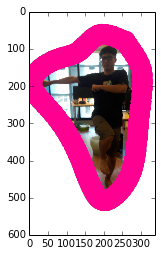

In [14]:
#rm bg
from Transparent_bg import TransparentBg
from PIL import Image,ImageDraw

img_poly = Image.open(test_image)
outputimg = TransparentBg(img_poly,points)

cv.drawContours(outputimg, np.asarray(points_draw), -1, (255, 0, 145, 1000), ptS*10)
outputimg = cv.resize(outputimg,(newWid, newHei), interpolation = cv.INTER_CUBIC)

plt.imshow(outputimg)

#save img
outdir = './rm_bg_output/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
cv.imwrite( outdir+file_id+"_rm_bg.png",outputimg[:,:,[2,1,0,3]]);